In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import libraries for ML algorithms: training, metrics, evaluation

# check sklearn version
from sklearn import __version__

# importing feature engineering tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# importing ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# importing model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# importing model metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# importing pipeline
from sklearn.pipeline import make_pipeline

In [3]:
# import libraries to save models
import pickle

### Help functions used in this notebook

In [4]:
def print_evaluation(mse, mae, r2, model_name):
    '''Print nicely the evaluation metrics of the model. 
    Inputs: mse, mae, r2 arefloats. model_name is str. 
    Return None'''
    print(f'Mean squared error ({model_name}) =', mse)
    print(f'Mean absolute error ({model_name}) =', mae)
    print(f'r2 score ({model_name}) =', r2)

### Loading Data from hard disk

In [5]:
# load cleaned data set
cleaned_df = pd.read_csv("../datasets/cleaned/cleaned_daily_irr.csv", sep=',', index_col=0, parse_dates=True )

In [6]:
cleaned_df.head(3)

,month,year,daily_temp,daily_rain,daily_hum,daily_press,daily_windDir,daily_windSp,daily_DHI,daily_DNI,daily_GHI
2019-08-31,8,2019,25.8,38.2,61.6,990.2,148.7,2.2,140.6,203.7,273.4
2019-09-01,9,2019,26.1,40.3,61.6,987.5,25.0,2.8,216.9,63.1,255.5
2019-09-02,9,2019,24.9,33.0,67.7,989.6,282.2,3.6,222.1,230.7,377.3


### Divide the data into train, test, and validation: 70% train, 15% val, 15% test

In [7]:
# split(data,[first_index, second_ndex]) divides the data into 3 parts: first part from beginnig to first_index-1,
# second part from first_index to second_index-1 and last part from second_index to the end.
#df.sample(frac=1) returns the entire df (because frac=1) shuffled
train_data, val_data, test_data = np.split(cleaned_df.sample(frac=1), [int(0.7*len(cleaned_df)), int(0.85*len(cleaned_df))])

#alternative method using sample(n=len(cleanded_df)) instead sample(frac=1)
#train_data, val_data, test_data = np.split(cleaned_df.sample(n=len(cleaned_df)),[int(0.7*len(cleaned_df)), int(0.85*len(cleaned_df))])

In [8]:
# saving the generated splitted data
train_data.to_csv("../datasets/cleaned/train.csv", header=True, index=False)
val_data.to_csv("../datasets/cleaned/validation.csv", header=True, index=False)
test_data.to_csv("../datasets/cleaned/test.csv", header=True, index=False)

In [9]:
# training data
train_df = pd.read_csv("../datasets/cleaned/train.csv", sep=',')
X_train = train_df.drop(columns=['daily_GHI'], axis=1)
y_train = train_df['daily_GHI']

In [10]:
# test data
test_df = pd.read_csv("../datasets/cleaned/test.csv", sep=',')
X_test = test_df.drop(columns=['daily_GHI'], axis=1)
y_test = test_df['daily_GHI']

### Feature Engineering

In [11]:
X_train.head(0)

,month,year,daily_temp,daily_rain,daily_hum,daily_press,daily_windDir,daily_windSp,daily_DHI,daily_DNI


In [12]:
feat_eng = ColumnTransformer(
                    [
                        ('OneHot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['month', 'year']),
                        ('StandardScaler', StandardScaler(), ['daily_temp', 'daily_rain', 'daily_hum',
                                                               'daily_press', 'daily_windDir', 'daily_windSp',
                                                                'daily_DHI', 'daily_DNI']),
                        #('KBin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'),
                        #    ['daily_temp', 'daily_rain', 'daily_hum',
                        #     'daily_press', 'daily_windDir', 'daily_windSp',
                        #     'daily_DHI', 'daily_DNI'])
                        #('KBin_OneHot', 
                        # make_pipeline(
                        #    KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'),
                        #    KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform')
                        #              ),
                        #['daily_temp', 'daily_rain', 'daily_hum','daily_press', 'daily_windDir',
                        #  'daily_windSp','daily_DHI', 'daily_DNI']
                        #)
                        
                    ], 
                        remainder='drop')

### Linear Regression

#### Fitting and prediction (LinearRegression)

In [13]:
# create pipeline
pipeline_lr = make_pipeline(feat_eng, LinearRegression())
# fit
pipeline_lr.fit(X_train, y_train)
# predict
y_pred_lr = pipeline_lr.predict(X_test)

In [14]:
#pipeline_lr.get_params()

#### Evaluation (LinearRegression)

In [15]:
# mean squared error
mse_lr = mean_squared_error(y_test, y_pred_lr)
# mean absolute error
mae_lr = mean_absolute_error(y_test, y_pred_lr)
# r2 score
r2_lr = r2_score(y_test, y_pred_lr)

In [16]:
print_evaluation(mse_lr, mae_lr, r2_lr, 'Linear Regression')

Mean squared error (Linear Regression) = 626.6388188976377
Mean absolute error (Linear Regression) = 20.633858267716533
r2 score (Linear Regression) = 0.9691063045909911


#### Plot predicted values against true values for test data (Linear Regression)

In [17]:
# generating a regression line 
yt = y_test.to_numpy().reshape(-1,1)
lr_model = LinearRegression()
linear_fit = lr_model.fit(yt, y_pred_lr)
linear_pred = linear_fit.predict(yt)

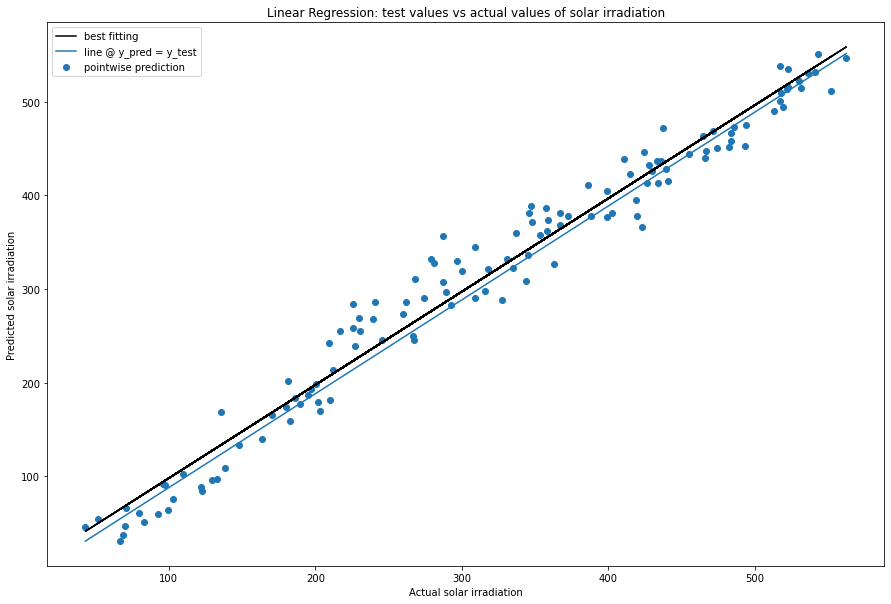

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.scatter(y_test, y_pred_lr, label = 'pointwise prediction')
ax.plot(y_test, linear_pred, 'black', label='best fitting')

ax.plot([y_test.min(), y_test.max()], [y_pred_lr.min(), y_pred_lr.max()], label='line @ y_pred = y_test')

ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title('Linear Regression: test values vs actual values of solar irradiation')
plt.legend(loc='upper left')
plt.show()

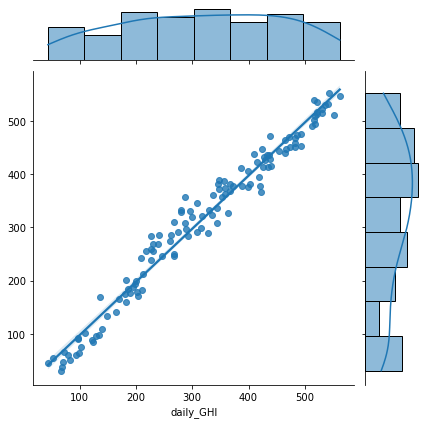

In [19]:
# seaborn jointplot
sns.jointplot(x=y_test, y=y_pred_lr, kind='reg')
plt.savefig('../pictures/lr_jointplot.jpg')
plt.show()

### Random Forest Regressor

#### Fitting and prediction (Random Forest Regressor)

In [20]:
# create pipeline
pipeline_rf = make_pipeline(feat_eng, RandomForestRegressor())
# fit
pipeline_rf.fit(X_train, y_train)
# predict
y_pred_rf = pipeline_rf.predict(X_test)

#### Evaluation (Random Forest Regressor)

In [21]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [22]:
print_evaluation(mse_rf, mae_rf, r2_rf, 'Random Forest Regressor')

Mean squared error (Random Forest Regressor) = 1103.4702343228332
Mean absolute error (Random Forest Regressor) = 22.087944881889747
r2 score (Random Forest Regressor) = 0.9455982101906043


#### Plot predicted values against true values for test data (Random Forest Regressor)

In [23]:
# generating a regression line 
linear_fit = lr_model.fit(yt, y_pred_rf)
linear_pred = linear_fit.predict(yt)

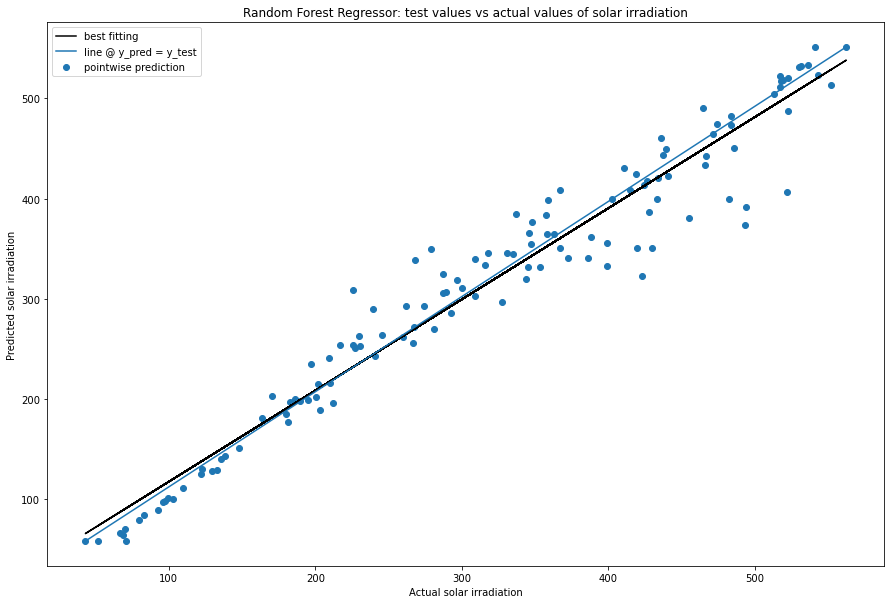

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.scatter(y_test, y_pred_rf, label = 'pointwise prediction')
ax.plot(y_test, linear_pred, 'black', label='best fitting')

ax.plot([y_test.min(), y_test.max()], [y_pred_rf.min(), y_pred_rf.max()], label='line @ y_pred = y_test')

ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title('Random Forest Regressor: test values vs actual values of solar irradiation')
plt.legend(loc='upper left')
plt.show()

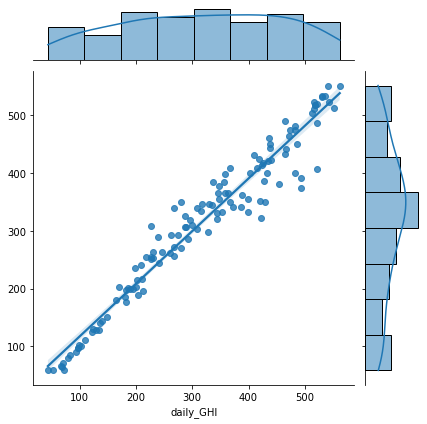

In [25]:
#seaborn jointplot
sns.jointplot(x=y_test, y=y_pred_rf, kind='reg')
plt.savefig('../pictures/rf_jointplot.jpg')
plt.show()

### Gradient Boosting Regressor

#### Fitting and prediction (Gradient Boosting Regressor)

In [26]:
# create pipeline
pipeline_gbr = make_pipeline(feat_eng, GradientBoostingRegressor())
# fit
pipeline_gbr.fit(X_train, y_train)
# predict
y_pred_gbr = pipeline_gbr.predict(X_test)

#### Evaluation (Gradient Boosting Regressor)

In [27]:
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

In [28]:
print_evaluation(mse_gbr, mae_gbr, r2_gbr, 'Gradient Boosting Regressor')

Mean squared error (Gradient Boosting Regressor) = 856.9132591393549
Mean absolute error (Gradient Boosting Regressor) = 20.28332502120505
r2 score (Gradient Boosting Regressor) = 0.9577536270951692


#### Plot predicted values against true values for test data (Gradient Boosting Regressor)

In [29]:
# generating a regression line 
linear_fit = lr_model.fit(yt, y_pred_gbr)
linear_pred = linear_fit.predict(yt)

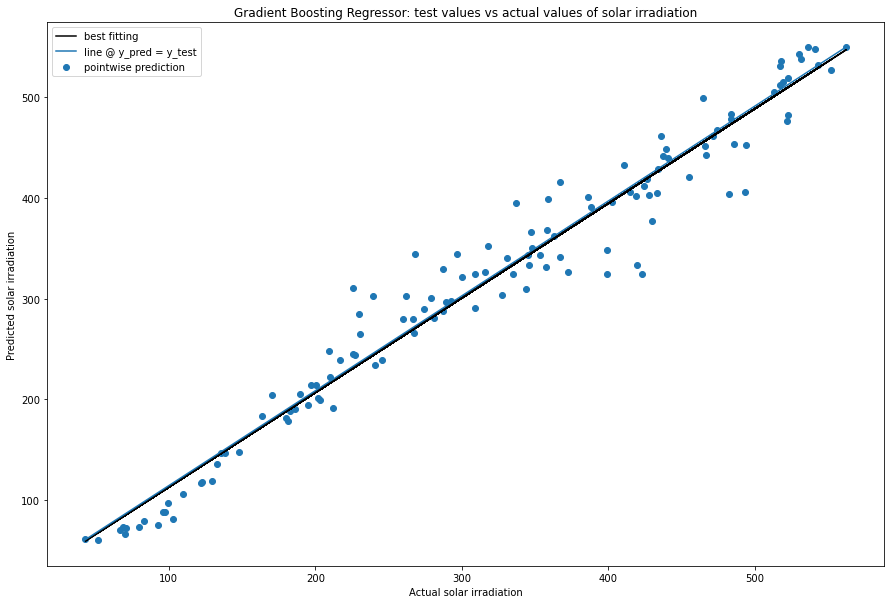

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.scatter(y_test, y_pred_gbr, label = 'pointwise prediction')
ax.plot(y_test, linear_pred, 'black', label='best fitting')

ax.plot([y_test.min(), y_test.max()], [y_pred_gbr.min(), y_pred_gbr.max()], label='line @ y_pred = y_test')

ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title('Gradient Boosting Regressor: test values vs actual values of solar irradiation')
plt.legend(loc='upper left')
plt.show()

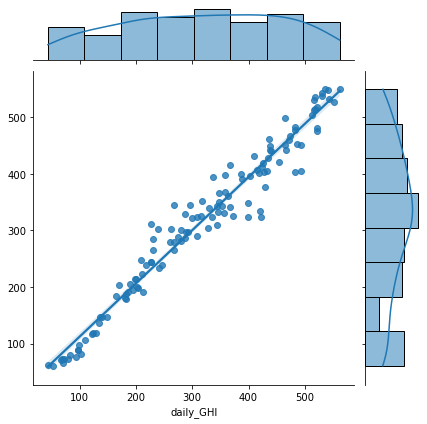

In [31]:
#seaborn jointplot
sns.jointplot(x=y_test, y=y_pred_gbr, kind='reg')
plt.savefig('../pictures/gbr_jointplot.jpg')
plt.show()

### Find the best parameters and model

In [32]:
parameters = {
    'columntransformer__OneHot':['passthrough', OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'columntransformer__StandardScaler':['passthrough', StandardScaler(), MinMaxScaler(),
                                         Normalizer(), RobustScaler()],
    'linearregression': [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]
}

In [33]:
grid_search = GridSearchCV(
    estimator = pipeline_lr,
    param_grid = parameters, 
    cv=5, 
    return_train_score=True, 
    scoring= 'neg_mean_squared_error',
    #n_jobs=4 # use all 4 CPU cores in parallel
)

In [34]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('OneHot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['month',
                                                                          'year']),
                                                                        ('StandardScaler',
                                                                         StandardScaler(),
                                                                         ['daily_temp',
                                                                          'daily_rain',
                                                                          'daily_hum',
           

In [35]:
best_params = grid_search.best_params_

#### Best parameters and best model are...

In [36]:
best_params

{'columntransformer__OneHot': 'passthrough',
 'columntransformer__StandardScaler': RobustScaler(),
 'linearregression': GradientBoostingRegressor()}

### Try again the prediction using the best parameters and best model

In [37]:
best_feat_eng = ColumnTransformer(
                    [
                        ('StandardScaler', RobustScaler(), ['daily_temp', 'daily_rain', 'daily_hum',
                                                               'daily_press', 'daily_windDir', 'daily_windSp',
                                                                'daily_DHI', 'daily_DNI']),
                        
                    ], 
                        remainder='passthrough')

In [38]:
# create pipeline
pipeline_gbr = make_pipeline(best_feat_eng, GradientBoostingRegressor())
# fit
pipeline_gbr.fit(X_train, y_train)
# predict
y_pred_gbr = pipeline_gbr.predict(X_test)

In [39]:
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

In [40]:
print_evaluation(mse_gbr, mae_gbr, r2_gbr, 'Gradient Boosting Regressor')

Mean squared error (Gradient Boosting Regressor) = 450.06053713791897
Mean absolute error (Gradient Boosting Regressor) = 15.556940864210034
r2 score (Gradient Boosting Regressor) = 0.97781172705768


<!DOCTYPE html>
<html>
    <body>
<span style="color: green"> Conclusions:  
    <p>The best model for predicting daily GHI in my city is <b>Gradient Boosting Regressor</b></p>
    <p>Best parameters for feature engineering:</p>
    <ul>
        <li><b>RobustScaler</b> for all features but "month" and "year".</li>
        <li>For "month" and "year" the best strategy is <b>passtrhough</b></li>
    </ul>
</span>
    </body>    
</html>

### Validation of the models using validation data

In [41]:
# validation data
val_df = pd.read_csv("../datasets/cleaned/validation.csv", sep=',')
X_val = val_df.drop(columns=['daily_GHI'], axis=1)
y_val = val_df['daily_GHI']

#### Prediction with linear regressor on validation data

In [42]:
y_valPred_lr = pipeline_lr.predict(X_val)

In [43]:
# evaluation linear regressor on validation data
mse_lr = mean_squared_error(y_val, y_valPred_lr)
mae_lr = mean_absolute_error(y_val, y_valPred_lr)
r2_lr = r2_score(y_val, y_valPred_lr)

print_evaluation(mse_lr, mae_lr, r2_lr, "Linear Regressor (validation)")

Mean squared error (Linear Regressor (validation)) = 864.3712007874016
Mean absolute error (Linear Regressor (validation)) = 22.187007874015748
r2 score (Linear Regressor (validation)) = 0.9516349307641638


#### Prediction with Random Forest on validation data

In [44]:
y_valPred_rf = pipeline_rf.predict(X_val)

In [45]:
# evaluation Random Forest on validation data
mse_rf = mean_squared_error(y_val, y_valPred_rf)
mae_rf = mean_absolute_error(y_val, y_valPred_rf)
r2_rf = r2_score(y_val, y_valPred_rf)

print_evaluation(mse_rf, mae_rf, r2_rf, "Random Forest (validation)")

Mean squared error (Random Forest (validation)) = 592.1076276456688
Mean absolute error (Random Forest (validation)) = 17.41197637795276
r2 score (Random Forest (validation)) = 0.966869180301169


#### Prediction with Gradient Boosting Regressor on validation data

In [46]:
# gbr using the best parameters as estimated on the previous section
y_vaPred_gbr = pipeline_gbr.predict(X_val)

In [47]:
mse_gbr = mean_squared_error(y_val, y_vaPred_gbr)
mae_gbr = mean_absolute_error(y_val, y_vaPred_gbr)
r2_gbr = r2_score(y_val, y_vaPred_gbr)

print_evaluation(mse_gbr, mae_gbr, r2_gbr, "Gradient Boosting Regressor (validation)")

Mean squared error (Gradient Boosting Regressor (validation)) = 442.755331284344
Mean absolute error (Gradient Boosting Regressor (validation)) = 16.10267956118331
r2 score (Gradient Boosting Regressor (validation)) = 0.9752260461331939


### Export models

In [48]:
# saving linear regressor model
pickle.dump(pipeline_lr, open("../models/lr_model.pkl", "wb"))

In [49]:
# saving Random Forest Regressor model
pickle.dump(pipeline_rf, open("../models/rf_model.pkl", "wb"))

In [50]:
# saving Gradient Boosting Regressor model
pickle.dump(pipeline_gbr, open("../models/gbr_model.pkl", "wb"))